In [ ]:
import os
import glob
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from speechbrain.pretrained import EncoderClassifier, SpeakerRecognition
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import torchaudio

In [6]:
verification = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="./models/ecapa_voxceleb",
    run_opts={"device": "cpu"}
)

c:\Users\Admin\.conda\envs\scass2\lib\site-packages\speechbrain\utils\checkpoints.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(path, map_location=device)

In [7]:
score, prediction = verification.verify_files("ECAPA-TDNN\\data\\american\\speaker_01\\american_s01_001.wav", "ECAPA-TDNN\\data\\american\\speaker_02\\american_s02_001.wav")
print(score, prediction)

tensor([0.1919]) tensor([False])


In [8]:
classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="./pretrained_models",
    run_opts={"device": "cuda" if torch.cuda.is_available() else "cpu"}
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Scan data
data_root = "./ECAPA-TDNN/data"  # Change to your AccentDB path

dataset = {}
file_list = []

print("Scanning AccentDB dataset...")

for accent in sorted(os.listdir(data_root)):
    accent_path = os.path.join(data_root, accent)
    if not os.path.isdir(accent_path):
        continue
    
    for speaker in sorted(os.listdir(accent_path)):
        speaker_path = os.path.join(accent_path, speaker)
        if not os.path.isdir(speaker_path):
            continue
        
        speaker_id = f"{accent}_{speaker}"
        
        wav_files = sorted(glob.glob(os.path.join(speaker_path, "*.wav")))
        
        if speaker_id not in dataset:
            dataset[speaker_id] = []
        
        for wav_file in wav_files:
            dataset[speaker_id].append(wav_file)
            file_list.append({
                'accent': accent,
                'speaker': speaker,
                'speaker_id': speaker_id,
                'wav_file': wav_file
            })

print(f"Found {len(dataset)} speakers")
print(f"Total audio files: {len(file_list)}")

for speaker_id, files in sorted(dataset.items())[:5]:
    print(f"  {speaker_id}: {len(files)} files")

Scanning AccentDB dataset...
✓ Found 23 speakers
✓ Total audio files: 17313
  american_speaker_01: 742 files
  american_speaker_02: 742 files
  american_speaker_03: 742 files
  american_speaker_04: 742 files
  american_speaker_05: 742 files


In [ ]:
print("Extracting embeddings for all audio files...")

embeddings = {}
embedding_data = []

for accent in sorted(os.listdir(data_root)):
    accent_path = os.path.join(data_root, accent)
    if not os.path.isdir(accent_path):
        continue
    
    for speaker in sorted(os.listdir(accent_path)):
        speaker_path = os.path.join(accent_path, speaker)
        if not os.path.isdir(speaker_path):
            continue
        
        speaker_id = f"{accent}_{speaker}"
        
        if speaker_id not in embeddings:
            embeddings[speaker_id] = []
        
        wav_files = sorted(glob.glob(os.path.join(speaker_path, "*.wav")))
        
        for wav_file in tqdm(wav_files, desc=f"Processing {speaker_id}"):
            try:                
                signal, fs = torchaudio.load(wav_file)
                
                # Resample to 16kHz
                if fs != 16000:
                    resampler = torchaudio.transforms.Resample(fs, 16000)
                    signal = resampler(signal)
                
                # Ensure mono
                if signal.shape[0] > 1:
                    signal = torch.mean(signal, dim=0, keepdim=True)
                
                # Extract embedding from tensor
                emb = classifier.encode_batch(signal).squeeze().cpu().numpy()
                embeddings[speaker_id].append(emb)
                
                embedding_data.append({
                    'accent': accent,
                    'speaker': speaker,
                    'speaker_id': speaker_id,
                    'wav_file': wav_file,
                    'embedding_norm': np.linalg.norm(emb)
                })
                
            except Exception as e:
                print(f"Error processing {wav_file}: {e}")

print(f"Extracted {sum(len(v) for v in embeddings.values())} embeddings")

# Create DataFrame
df_embeddings = pd.DataFrame(embedding_data)
print("\nEmbedding metadata:")
print(df_embeddings.head())


Extracting embeddings for all audio files...


Processing american_speaker_01:   0%|          | 0/742 [00:00<?, ?it/s]

Processing welsh_speaker_01: 100%|██████████| 742/742 [06:13<00:00,  1.98it/s]


✓ Extracted 17313 embeddings

Embedding metadata:
     accent     speaker           speaker_id  \
0  american  speaker_01  american_speaker_01   
1  american  speaker_01  american_speaker_01   
2  american  speaker_01  american_speaker_01   
3  american  speaker_01  american_speaker_01   
4  american  speaker_01  american_speaker_01   

                                            wav_file  embedding_norm  
0  ./ECAPA-TDNN/data\american\speaker_01\american...      299.698151  
1  ./ECAPA-TDNN/data\american\speaker_01\american...      341.315979  
2  ./ECAPA-TDNN/data\american\speaker_01\american...      347.348358  
3  ./ECAPA-TDNN/data\american\speaker_01\american...      337.071442  
4  ./ECAPA-TDNN/data\american\speaker_01\american...      346.432983  


In [ ]:
print("Computing cosine similarity within speakers...")

similarity_results = []

for speaker_id, embs in tqdm(embeddings.items(), desc="Computing similarities"):
    if len(embs) < 2:
        continue
    
    embs_array = np.array(embs)
    
    
    embs_normalized = embs_array / (np.linalg.norm(embs_array, axis=1, keepdims=True) + 1e-8)
    
    # pairwise similarities
    similarities = []
    
    for i in range(len(embs_normalized)):
        for j in range(i+1, len(embs_normalized)):
            sim = np.dot(embs_normalized[i], embs_normalized[j])
            similarities.append({
                'speaker_id': speaker_id,
                'file_i': i,
                'file_j': j,
                'similarity': sim
            })
    
    if similarities:
        sims = np.array([s['similarity'] for s in similarities])
        similarity_results.append({
            'speaker_id': speaker_id,
            'num_utterances': len(embs),
            'mean_similarity': np.mean(sims),
            'std_similarity': np.std(sims),
            'min_similarity': np.min(sims),
            'max_similarity': np.max(sims),
            'num_pairs': len(sims)
        })

df_similarity = pd.DataFrame(similarity_results)

print("\nCosine Similarity Results (Within Speakers):")
print(df_similarity)

# Show statistics
print("\nSTATISTICS:")
print(f"Mean similarity (across all speakers): {df_similarity['mean_similarity'].mean():.4f}")
print(f"Std of mean similarities: {df_similarity['mean_similarity'].std():.4f}")
print(f"Min similarity: {df_similarity['min_similarity'].min():.4f}")
print(f"Max similarity: {df_similarity['max_similarity'].max():.4f}")


Computing cosine similarity within speakers...


Computing similarities: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s]


✓ Cosine Similarity Results (Within Speakers):
               speaker_id  num_utterances  mean_similarity  std_similarity  \
0     american_speaker_01             742         0.675620        0.091484   
1     american_speaker_02             742         0.685645        0.087579   
2     american_speaker_03             742         0.633789        0.089173   
3     american_speaker_04             742         0.560076        0.092232   
4     american_speaker_05             742         0.703128        0.088436   
5     american_speaker_06             742         0.691704        0.087867   
6     american_speaker_07             742         0.710977        0.073965   
7     american_speaker_08             742         0.653634        0.091543   
8   australian_speaker_01             742         0.627838        0.088097   
9   australian_speaker_02             742         0.628114        0.092351   
10      bangla_speaker_01             778         0.639096        0.072441   
11      bangla_s

In [ ]:
print("Computing cosine similarity between different speakers...")

speaker_embeddings = {}

for speaker_id, embs in embeddings.items():
    if len(embs) > 0:
        avg_emb = np.mean(np.array(embs), axis=0)
        speaker_embeddings[speaker_id] = avg_emb

# pairwise similarities between speakers
between_speaker_sims = []

speaker_ids = list(speaker_embeddings.keys())

for i in tqdm(range(len(speaker_ids)), desc="Computing between-speaker similarities"):
    for j in range(i+1, len(speaker_ids)):
        speaker_id_i = speaker_ids[i]
        speaker_id_j = speaker_ids[j]
        
        emb_i = speaker_embeddings[speaker_id_i]
        emb_j = speaker_embeddings[speaker_id_j]
        
        # Normalize
        emb_i_norm = emb_i / (np.linalg.norm(emb_i) + 1e-8)
        emb_j_norm = emb_j / (np.linalg.norm(emb_j) + 1e-8)
        
        sim = np.dot(emb_i_norm, emb_j_norm)
        
        accent_i = speaker_id_i.split('_')
        accent_j = speaker_id_j.split('_')
        same_accent = accent_i == accent_j
        
        between_speaker_sims.append({
            'speaker_i': speaker_id_i,
            'speaker_j': speaker_id_j,
            'accent_i': accent_i,
            'accent_j': accent_j,
            'same_accent': same_accent,
            'similarity': sim
        })

df_between = pd.DataFrame(between_speaker_sims)

print("\nCosine Similarity Results (Between Speakers):")
print(df_between.head(10))

# Statistics
print("\nBETWEEN-SPEAKER STATISTICS:")
print(f"Mean similarity (different speakers): {df_between['similarity'].mean():.4f}")
print(f"Std: {df_between['similarity'].std():.4f}")
print(f"Min: {df_between['similarity'].min():.4f}")
print(f"Max: {df_between['similarity'].max():.4f}")

# Compare same accent vs different accent
same_accent_sims = df_between[df_between['same_accent'] == True]['similarity']
diff_accent_sims = df_between[df_between['same_accent'] == False]['similarity']

print(f"\nSame accent speakers: {same_accent_sims.mean():.4f} ± {same_accent_sims.std():.4f}")
print(f"Different accent speakers: {diff_accent_sims.mean():.4f} ± {diff_accent_sims.std():.4f}")


Computing cosine similarity between different speakers...


Computing between-speaker similarities: 100%|██████████| 23/23 [00:00<00:00, 4030.29it/s]


✓ Cosine Similarity Results (Between Speakers):
             speaker_i              speaker_j                 accent_i  \
0  american_speaker_01    american_speaker_02  [american, speaker, 01]   
1  american_speaker_01    american_speaker_03  [american, speaker, 01]   
2  american_speaker_01    american_speaker_04  [american, speaker, 01]   
3  american_speaker_01    american_speaker_05  [american, speaker, 01]   
4  american_speaker_01    american_speaker_06  [american, speaker, 01]   
5  american_speaker_01    american_speaker_07  [american, speaker, 01]   
6  american_speaker_01    american_speaker_08  [american, speaker, 01]   
7  american_speaker_01  australian_speaker_01  [american, speaker, 01]   
8  american_speaker_01  australian_speaker_02  [american, speaker, 01]   
9  american_speaker_01      bangla_speaker_01  [american, speaker, 01]   

                    accent_j  same_accent  similarity  
0    [american, speaker, 02]        False    0.189517  
1    [american, speaker,

In [ ]:
print("="*60)
print("EMBEDDING QUALITY SUMMARY")
print("="*60)

within_sim = df_similarity['mean_similarity'].mean()
between_sim = df_between['similarity'].mean()
separation = within_sim - between_sim

print(f"\n✓ Same speaker similarity: {within_sim:.4f}")
print(f"✓ Different speaker similarity: {between_sim:.4f}")
print(f"✓ Separation gap: {separation:.4f}")

# Check if separation is good
if separation > 0.3:
    print("\nGOOD: Embeddings well separate speakers!")
elif separation > 0.15:
    print("\nMODERATE: Some separation exists")
else:
    print("\nPOOR: Embeddings may not distinguish speakers well")

print("\n" + "="*60)


EMBEDDING QUALITY SUMMARY

✓ Same speaker similarity: 0.6497
✓ Different speaker similarity: 0.1435
✓ Separation gap: 0.5062

✅ GOOD: Embeddings well separate speakers!



C:\Users\Admin\AppData\Local\Temp\ipykernel_6468\1008470751.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Same Speaker', 'Different Speakers'], patch_artist=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_6468\1008470751.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Same Accent', 'Different Accent'], patch_artist=True)


✓ Saved visualization to: cosine_similarity_analysis.png


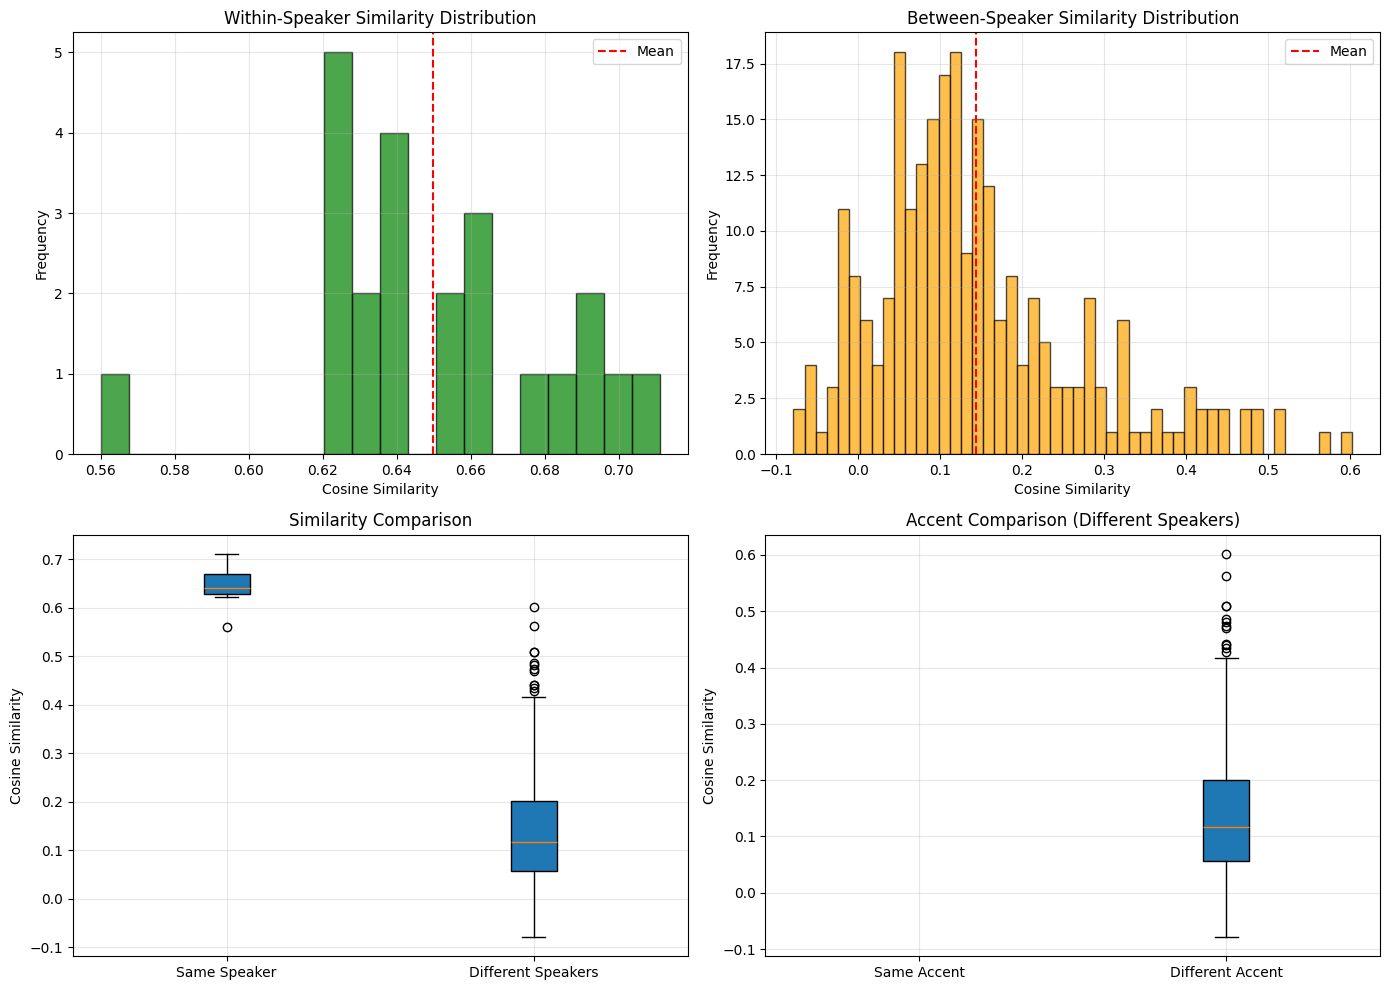

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Within-speaker similarity distribution
ax = axes[0, 0]
ax.hist(df_similarity['mean_similarity'], bins=20, color='green', alpha=0.7, edgecolor='black')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Frequency')
ax.set_title('Within-Speaker Similarity Distribution')
ax.axvline(df_similarity['mean_similarity'].mean(), color='red', linestyle='--', label='Mean')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Between-speaker similarity distribution
ax = axes[0, 1]
ax.hist(df_between['similarity'], bins=50, color='orange', alpha=0.7, edgecolor='black')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Frequency')
ax.set_title('Between-Speaker Similarity Distribution')
ax.axvline(df_between['similarity'].mean(), color='red', linestyle='--', label='Mean')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Box plot comparison
ax = axes[1, 0]
data_to_plot = [
    df_similarity['mean_similarity'].values,
    df_between['similarity'].values
]
bp = ax.boxplot(data_to_plot, labels=['Same Speaker', 'Different Speakers'], patch_artist=True)
ax.set_ylabel('Cosine Similarity')
ax.set_title('Similarity Comparison')
ax.grid(True, alpha=0.3)

# Plot 4: Same accent vs different accent
ax = axes[1, 1]
same_accent_sims = df_between[df_between['same_accent'] == True]['similarity']
diff_accent_sims = df_between[df_between['same_accent'] == False]['similarity']
data_to_plot = [same_accent_sims.values, diff_accent_sims.values]
bp = ax.boxplot(data_to_plot, labels=['Same Accent', 'Different Accent'], patch_artist=True)
ax.set_ylabel('Cosine Similarity')
ax.set_title('Accent Comparison (Different Speakers)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cosine_similarity_analysis.png', dpi=150, bbox_inches='tight')
print("Saved visualization to: cosine_similarity_analysis.png")
plt.show()



📊 TOP 5 SPEAKERS (Best Within-Speaker Consistency):
             speaker_id  mean_similarity  num_utterances
6   american_speaker_07         0.710977             742
4   american_speaker_05         0.703128             742
5   american_speaker_06         0.691704             742
20    telugu_speaker_01         0.690572             766
1   american_speaker_02         0.685645             742

📊 BOTTOM 5 SPEAKERS (Lowest Within-Speaker Consistency):
              speaker_id  mean_similarity  num_utterances
3    american_speaker_04         0.560076             742
16  malayalam_speaker_01         0.621783             751
15     indian_speaker_02         0.622781             742
12    british_speaker_01         0.624304             742
22      welsh_speaker_01         0.625102             742
✓ Saved per-speaker visualization to: per_speaker_similarity.png


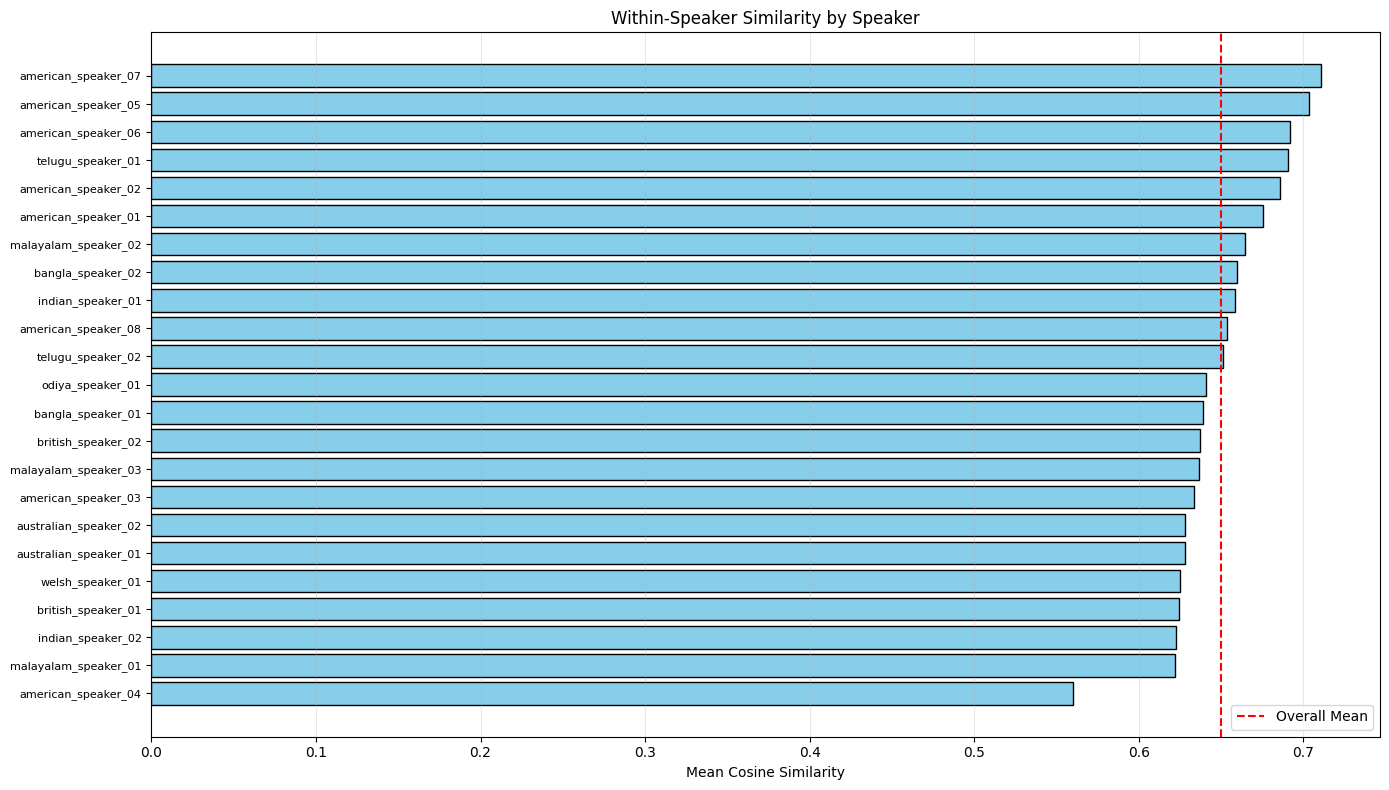

In [ ]:
# Show top speakers (highest within-speaker similarity)
print("\nTOP 5 SPEAKERS (Best Within-Speaker Consistency):")
top_speakers = df_similarity.nlargest(5, 'mean_similarity')
print(top_speakers[['speaker_id', 'mean_similarity', 'num_utterances']])

print("\nBOTTOM 5 SPEAKERS (Lowest Within-Speaker Consistency):")
bottom_speakers = df_similarity.nsmallest(5, 'mean_similarity')
print(bottom_speakers[['speaker_id', 'mean_similarity', 'num_utterances']])

# Create per-speaker visualization
fig, ax = plt.subplots(figsize=(14, 8))
df_sorted = df_similarity.sort_values('mean_similarity')
ax.barh(range(len(df_sorted)), df_sorted['mean_similarity'].values, color='skyblue', edgecolor='black')
ax.set_yticks(range(len(df_sorted)))
ax.set_yticklabels(df_sorted['speaker_id'].values, fontsize=8)
ax.set_xlabel('Mean Cosine Similarity')
ax.set_title('Within-Speaker Similarity by Speaker')
ax.axvline(df_sorted['mean_similarity'].mean(), color='red', linestyle='--', label='Overall Mean')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('per_speaker_similarity.png', dpi=150, bbox_inches='tight')
print("✓ Saved per-speaker visualization to: per_speaker_similarity.png")
plt.show()


In [ ]:
def compute_quality_metrics(within_sims, between_sims):
    """
    Compute metrics to assess embedding quality
    """
    
    # 1. Separation gap (larger = better)
    separation = within_sims.mean() - between_sims.mean()
    
    # 2. Intra-class consistency (variance within speakers)
    intra_consistency = 1 - within_sims.std()
    
    # 3. Inter-class separation (how well separated)
    inter_separation = (within_sims.min() - between_sims.max()) / (within_sims.max() - between_sims.min() + 1e-8)
    
    # 4. False positive rate at threshold 0.5
    threshold = 0.5
    false_positives = (between_sims > threshold).sum() / len(between_sims)
    
    return {
        'Separation Gap': separation,
        'Intra-class Consistency': intra_consistency,
        'Inter-class Separation': inter_separation,
        'False Positive Rate (threshold=0.5)': false_positives
    }

metrics = compute_quality_metrics(
    df_similarity['mean_similarity'].values,
    df_between['similarity'].values
)

print("\n" + "="*60)
print("EMBEDDING QUALITY METRICS")
print("="*60)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Interpretation
print("\nINTERPRETATION:")
print(f"Separation Gap > 0.3: Good separation" if metrics['Separation Gap'] > 0.3 else "Separation Gap < 0.3: Weak separation")
print(f"False Positive Rate < 0.1: Good thresholding" if metrics['False Positive Rate (threshold=0.5)'] < 0.1 else "False Positive Rate > 0.1: May need adjustment")



EMBEDDING QUALITY METRICS
Separation Gap: 0.5062
Intra-class Consistency: 0.9671
Inter-class Separation: -0.0532
False Positive Rate (threshold=0.5): 0.0158

📌 INTERPRETATION:
Separation Gap > 0.3: Good separation
False Positive Rate < 0.1: Good thresholding


Creating similarity heatmap...
✓ Saved heatmap to: similarity_heatmap.png


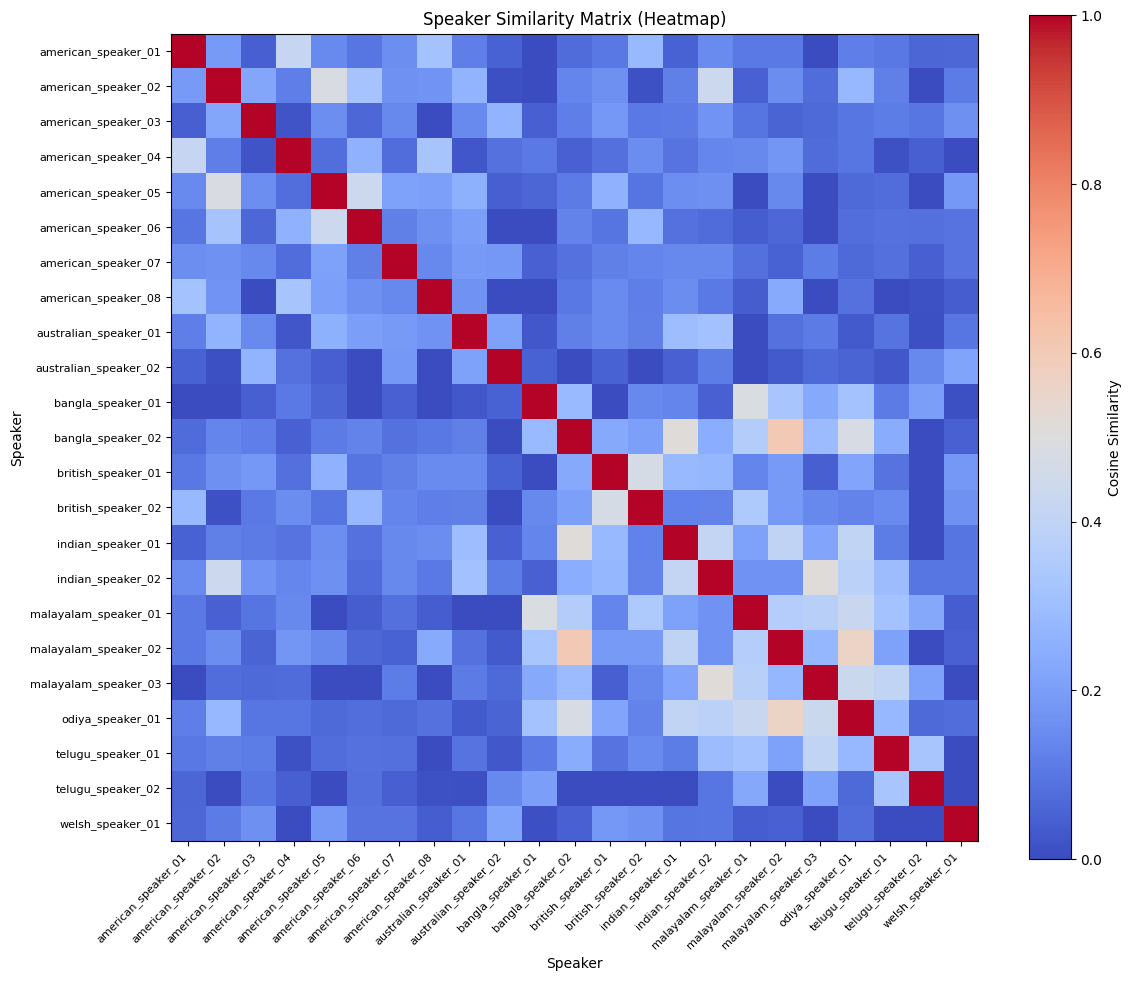

In [ ]:
# Only create heatmap if you have <= 30 speakers (otherwise too large)
if len(speaker_embeddings) <= 30:
    print("Creating similarity heatmap...")
    
    # Create similarity matrix
    speaker_ids = sorted(list(speaker_embeddings.keys()))
    n_speakers = len(speaker_ids)
    
    similarity_matrix = np.zeros((n_speakers, n_speakers))
    
    for i in range(n_speakers):
        for j in range(n_speakers):
            emb_i = speaker_embeddings[speaker_ids[i]]
            emb_j = speaker_embeddings[speaker_ids[j]]
            
            emb_i_norm = emb_i / (np.linalg.norm(emb_i) + 1e-8)
            emb_j_norm = emb_j / (np.linalg.norm(emb_j) + 1e-8)
            
            similarity_matrix[i, j] = np.dot(emb_i_norm, emb_j_norm)
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(similarity_matrix, cmap='coolwarm', vmin=0, vmax=1)
    
    ax.set_xticks(range(n_speakers))
    ax.set_yticks(range(n_speakers))
    ax.set_xticklabels(speaker_ids, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(speaker_ids, fontsize=8)
    
    ax.set_xlabel('Speaker')
    ax.set_ylabel('Speaker')
    ax.set_title('Speaker Similarity Matrix (Heatmap)')
    
    plt.colorbar(im, ax=ax, label='Cosine Similarity')
    plt.tight_layout()
    plt.savefig('similarity_heatmap.png', dpi=150, bbox_inches='tight')
    print("Saved heatmap to: similarity_heatmap.png")
    plt.show()
else:
    print(f"Skipping heatmap (too many speakers: {len(speaker_embeddings)})")
